In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
#Load dataset
file_path = "IMDb Movies India.csv"
df = pd.read_csv(file_path, encoding="latin1")

In [ ]:
# Data Cleaning
df.drop_duplicates(inplace=True)
df.dropna(subset=["Rating"], inplace=True)  # Drop rows with missing target values

df["Year"] = df["Year"].str.extract("(\\d{4})").astype(float)
df["Duration"] = df["Duration"].str.extract("(\\d+)").astype(float)
df["Votes"] = df["Votes"].str.replace(",", "").astype(float)

# Fill missing values
imputer = SimpleImputer(strategy="most_frequent")
df[["Genre", "Director", "Actor 1", "Actor 2", "Actor 3"]] = imputer.fit_transform(
    df[["Genre", "Director", "Actor 1", "Actor 2", "Actor 3"]]
)

In [ ]:
# Feature Engineering
df["Genre_Main"] = df["Genre"].apply(lambda x: x.split(",")[0])
df.drop(columns=["Name", "Genre"], inplace=True)

# Define Features and Target
X = df.drop(columns=["Rating"])
y = df["Rating"]

In [ ]:
# Preprocessing Pipeline
categorical_features = ["Genre_Main", "Director", "Actor 1", "Actor 2", "Actor 3"]
numeric_features = ["Year", "Duration", "Votes"]

num_imputer = SimpleImputer(strategy="median")  # Fill NaNs in numeric columns with median

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", num_imputer), ("scaler", StandardScaler())]), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

In [ ]:

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Training Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2 Score": r2_score(y_test, y_pred),
    }

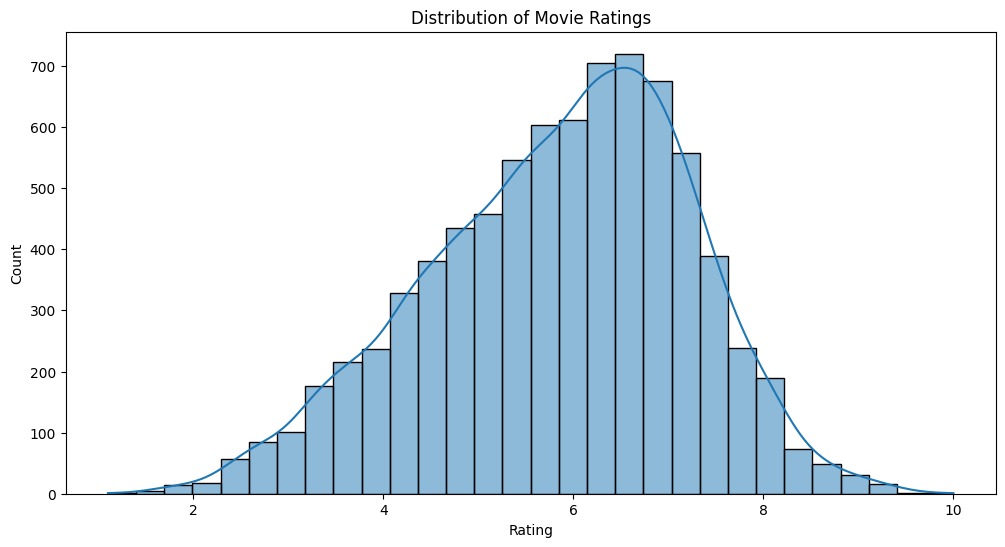

In [ ]:
#Individual Feature Analysis
plt.figure(figsize=(12, 6))
sns.histplot(df["Rating"], bins=30, kde=True)
plt.title("Distribution of Movie Ratings")
plt.show()

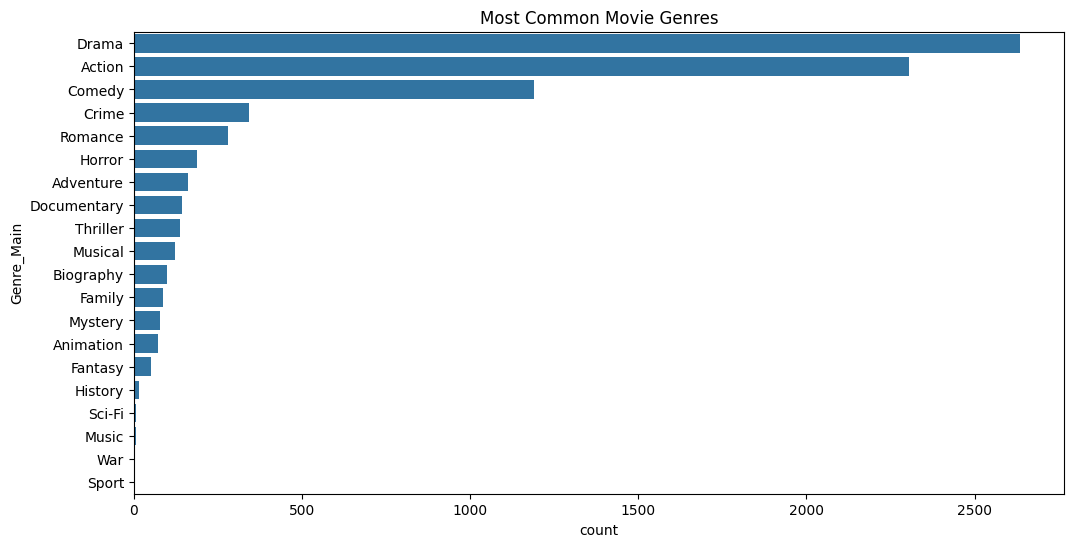

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(y=df["Genre_Main"], order=df["Genre_Main"].value_counts().index)
plt.title("Most Common Movie Genres")
plt.show()

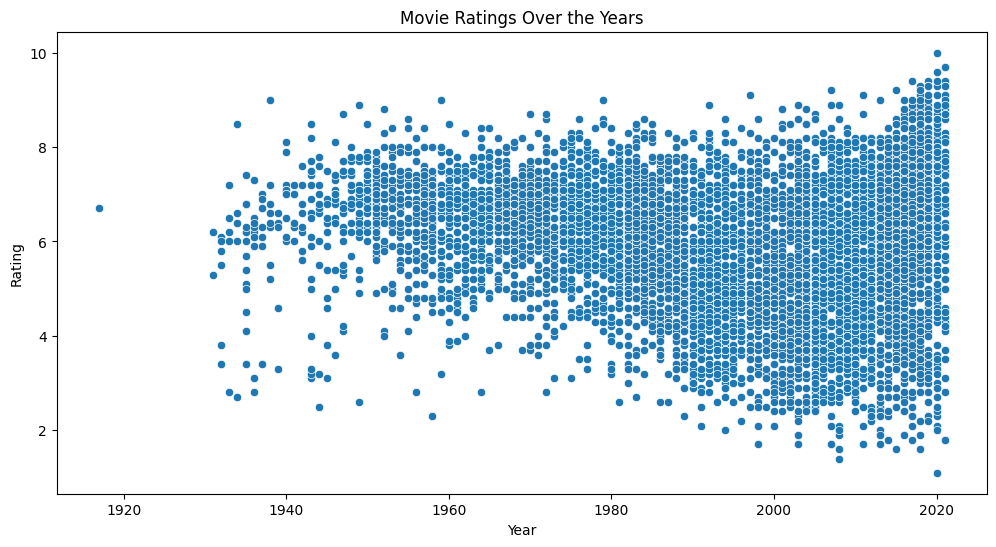

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df["Year"], y=df["Rating"])
plt.title("Movie Ratings Over the Years")
plt.show()

In [ ]:
# Display Results
for model, metrics in results.items():
    print(f"{model} Results:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print("-")

Linear Regression Results:
  MAE: 1.5862
  MSE: 5.0716
  RMSE: 2.2520
  R2 Score: -1.7279
-
Random Forest Results:
  MAE: 0.8068
  MSE: 1.1665
  RMSE: 1.0800
  R2 Score: 0.3726
-


In [16]:
def predict_movie_rating(model_pipeline, movie_features):
    # Convert input to DataFrame
    movie_df = pd.DataFrame([movie_features])

    #Predict rating
    predicted_rating = model_pipeline.predict(movie_df)[0]
    return predicted_rating

#Example Movie Data
new_movie = {
    "Year": 2025,
    "Duration": 135,
    "Votes": 20000,
    "Genre_Main": "Drama, Comedy",
    "Director": "Subhash Kapoor",
    "Actor 1": "Akshay Kumar",
    "Actor 2": "Arshad Warsi",
    "Actor 3": "Saurabh Shukla"
}

#Choosing a model (Random Forest)
best_model = models["Random Forest"]

#Creating a final pipeline with preprocessing and the chosen model
final_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", best_model)])

#Training the final model on full dataset
final_pipeline.fit(X, y)

#Predict rating
predicted_rating = predict_movie_rating(final_pipeline, new_movie)
print(f"Predicted Rating: {predicted_rating:.2f}")


Predicted Rating: 7.17
